# Atmospheric modeling of Wasp-127b with CO and H20 line species
We model an idealized atmosphere of Wasp-127b possessing species CO and H2O using petitRADTRANS. This allows us to get a model transmission spectrum of the planet that we can then cross correlate with CRIRES+ data in order to detect CO and H2O in its atmosphere. Based on Nortmann L. et al (2025).

In [16]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.constants as c

from petitRADTRANS.radtrans import Radtrans

from petitRADTRANS import physical_constants as cst
from petitRADTRANS.physics import temperature_profile_function_guillot_global

from petitRADTRANS.chemistry.pre_calculated_chemistry import PreCalculatedEquilibriumChemistryTable

Load Radtrans object with adequate pressures and CO, H2O lines. We focus on $1.9 - 2.5 \times 10^4 \AA$ wavelength range.

In [17]:
atmosphere = Radtrans(
    pressures=np.logspace(-6,2,100),
    line_species=['CO', 'H2O'],
    rayleigh_species=['H2', 'He'],
    gas_continuum_contributors=['H2-H2', 'H2-He'],
    wavelength_boundaries=[1.9, 2.5],
    line_opacity_mode='lbl'
)

Loading Radtrans opacities...
 Loading line opacities of species 'CO' from file '/Users/nathan/petitRADTRANS/input_data/opacities/lines/line_by_line/CO/12C-16O/12C-16O__HITEMP.R1e6_0.3-28mu.xsec.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O' from file '/Users/nathan/petitRADTRANS/input_data/opacities/lines/line_by_line/H2O/1H2-16O/1H2-16O__HITRAN.R1e6_0.3-28mu.xsec.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/Users/nathan/petitRADTRANS/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-NatAbund/H2--H2-NatAbund__BoRi.R831_0.6-250mu.ciatable.petitRADTRANS.h5'... Done.
 Loading CIA opacities for H2-He from file '/Users/nathan/petitRADTRANS/input_data/opacities/continuum/collision_induced_absorptions/H2--He/H2--He-NatAbund/H2--He-NatAbund__BoRi.DeltaWavenumber2_0.5-500mu.ciatable.petitRADTRANS.h5'... Done.
 Successfully loaded all CIA opacities
Successfully loaded all opacities


Calculate temperature curve of the atmosphere based on planetary parameters.

In [18]:
planet_radius = 1.311*cst.r_jup_mean
star_radius = 1.33*cst.r_sun

reference_gravity = 10**2.36
reference_pressure = 0.01  # may have to change this

pressures_bar = atmosphere.pressures*1e-6
kappa_IR = 10**-2.99
gamma = 10**-1.92
T_int = 500
T_equ = 1135

temperatures = temperature_profile_function_guillot_global(
    pressures_bar, kappa_IR, gamma, reference_gravity, T_int, T_equ
)

Calculate mass fractions and mean molar masses of CO species in the atmosphere.

In [19]:
chem = PreCalculatedEquilibriumChemistryTable()

COs = 0.55 * np.ones_like(pressures_bar)
FeHs = 0.0 * np.ones_like(pressures_bar)

mass_fractions, mean_molar_masses, _ = chem.interpolate_mass_fractions(COs, FeHs, temperatures, pressures_bar, full=True)

Loading chemical equilibrium chemistry table from file '/Users/nathan/petitRADTRANS/input_data/pre_calculated_chemistry/equilibrium_chemistry/equilibrium_chemistry.chemtable.petitRADTRANS.h5'... Done.


Finally, generate transmission spectrum

In [20]:
wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(
    temperatures=temperatures,
    mass_fractions=mass_fractions,
    mean_molar_masses=mean_molar_masses,
    reference_gravity=reference_gravity,
    planet_radius=planet_radius,
    reference_pressure=reference_pressure,
    opaque_cloud_top_pressure = 1e-3
)

wavelengths = wavelengths * 1e8
transit_radii = transit_radii / star_radius

Model transmission spectrum using the transit radius and wavelength

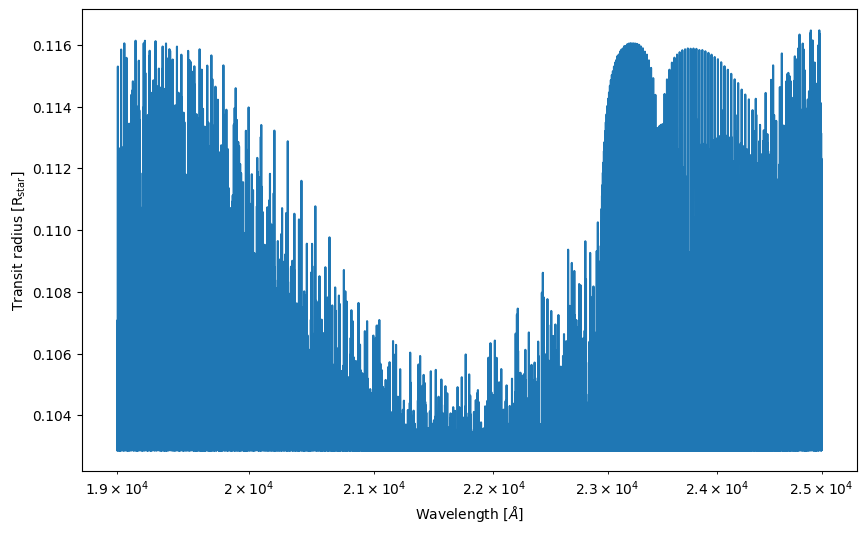

In [21]:
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(wavelengths, transit_radii)
ax.set_xscale('log')
ax.set_xlabel(r'Wavelength $[\AA]$')
ax.set_ylabel(r'Transit radius [$\rm R_{star}$]');

Convert transit radius to flux for the cross-correlation

In [22]:
flux = -transit_radii**2
model = flux - np.max(flux)

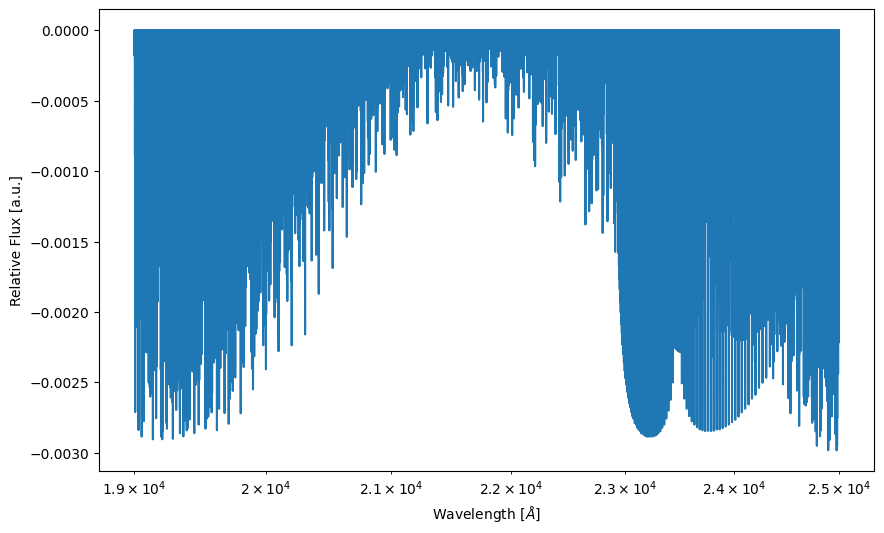

In [23]:
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(wavelengths, model)
ax.set_xscale('log')
ax.set_xlabel(r'Wavelength $[\AA]$')
ax.set_ylabel(r'Relative Flux [a.u.]');

In [24]:
np.savez('models_no_convolve/COH2O', wl_model=wavelengths, model=model)

Also tried model convolution (not necessary)

In [25]:
(wavelengths[1:]+wavelengths[:-1])/2/np.diff(wavelengths)

array([ 999999.99998068, 1000000.00011112, 1000000.0000511 , ...,
       1000000.00015056,  999999.99999578,  999999.99998752])

/var/folders/j9/q8hqts053r57j7y11x4bv2_c0000gn/T/ipykernel_2299/2807872850.py:11: RuntimeWarning: invalid value encountered in sqrt
  kernel = np.sqrt(1-v_equs**2)


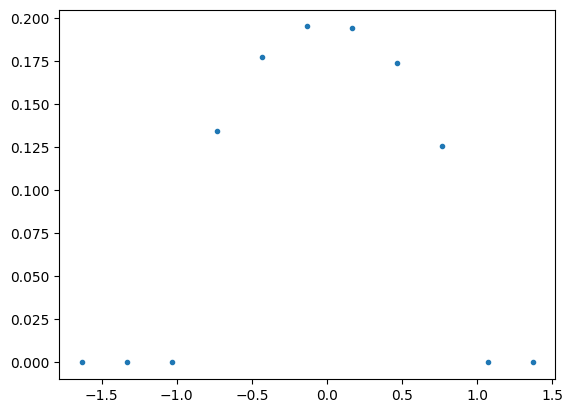

In [26]:
resolution = 1e6
delta_v = 3e5 / resolution  # in km/s

P = 4.17806203 * 24 * 3600 # period of system in s
R_planet = 1.311 * c.R_jup.value * 1e-3 # planet radius in km

circ = 2*np.pi*R_planet  # circumference at equator
v_equ = circ/P  # velocity at equator (km/s)

v_equs = np.arange(-v_equ, v_equ, delta_v)
kernel = np.sqrt(1-v_equs**2)

kernel[~np.isfinite(kernel)] = 0

kernel = kernel / kernel.sum()

plt.plot(v_equs, kernel, '.')

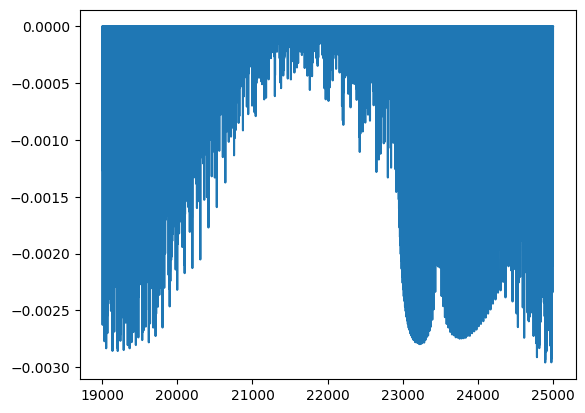

In [27]:
convoluted = np.convolve(model, kernel, mode='same')

plt.plot(wavelengths, convoluted)

In [28]:
np.savez('models_convolve/COH2O', wl_model=wavelengths, model=convoluted)